# 1-Rank Piecewise Warping

This notebook shows how to fit a 1-Rank piecewise linear warping model to real data.

In [2]:
import scipy as sp
import numpy as np
import os
import matplotlib.pyplot as plt
import copy
import itertools
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

In [3]:
%load_ext autoreload
%autoreload 2

#### Load Real Dataset

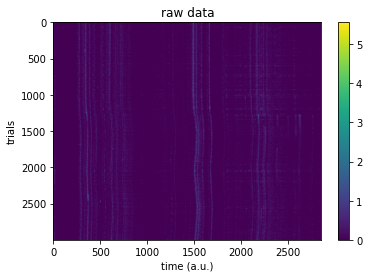

In [6]:
# load e-mouse data
data = np.load('/home/lorenlab/Documents/MATLAB/Kilosort/Shijie/NIckData/tmp_10ofsecond/data.npy').T
data=np.log(1+data)
data=np.expand_dims(data, axis=2)

# Plot data.
plt.imshow(np.squeeze(data), aspect='auto')
plt.title('raw data'), plt.xlabel('time (a.u.)'), plt.ylabel('trials')
plt.colorbar()

In [9]:
np.shape(data)

(3000, 2854, 1)

#### Fit a model to do the drift tracking

In [11]:
from affinewarp import PiecewiseWarping,Rank1_PiecewiseWarping

In [12]:
# Fit warping model.
model_r1pw4 = Rank1_PiecewiseWarping(n_knots=4, warp_reg_scale=0, smoothness_reg_scale=0, loss='rank1_norm2')
model_r1pw4.fit(data, iterations=20, warp_iterations=400)
recon_r1pw4=model_r1pw4.transform(data,init_warps=False).squeeze()

Loss improvement: 2.37%: 100%|██████████| 20/20 [09:56<00:00, 29.80s/it]


In [13]:
test=np.diff(model_r1pw4.y_knots)/np.diff(model_r1pw4.x_knots)

In [18]:
#plt.hist(test.ravel(),bins=100)

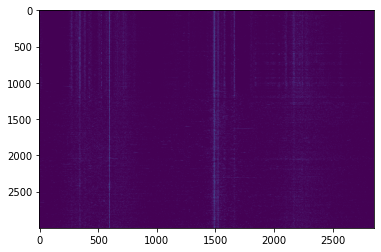

In [14]:
plt.imshow(recon_r1pw4,aspect='auto')

In [13]:
# Fit warping model.
model_pw4 = PiecewiseWarping(n_knots=4, warp_reg_scale=0, smoothness_reg_scale=0)
model_pw4.fit(data, iterations=20, warp_iterations=400)
recon_pw4=model_pw4.transform(data).squeeze()

Loss improvement: 1.53%: 100%|██████████| 20/20 [10:56<00:00, 32.81s/it]


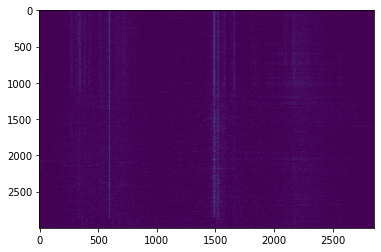

In [15]:
plt.imshow(recon_pw4,aspect='auto')

In [16]:
## save drift
import os
path='/home/lorenlab/Documents/MATLAB/Kilosort/Shijie/NIckData/tmp_10ofsecond/'
shift_datapath=os.path.join(path,'pw4_drift_10ofsecond.npy')
shifts=model_pw4.get_shift(data)*-1
np.save(shift_datapath,shifts.squeeze())

shift_datapath=os.path.join(path,'r1pw4_drift_10ofsecond.npy')
shifts=model_r1pw4.get_shift(data)*-1
np.save(shift_datapath,shifts.squeeze())

In [17]:
def apply_shift(data,shift,out):
    K = out.shape[0]
    T = out.shape[1]

    for k in range(K):

        # iterate over all time bins.
        for t in range(T):

            # compute index in warped time
            _i = t-shift[k,t]

            if _i <= 0:
                out[k, t] = data[k, 0]
            elif _i >= T-1:
                out[k, t] = data[k, -1]
            else:
                rem = _i % 1
                i = int(_i)
                out[k, t] = (1-rem) * data[k, i] + rem * data[k, i+1]
    return out

In [18]:
# 2D Histogram Image Alignment Model
shift=np.load(os.path.join(path,'benchmark_drift_10ofsecond.npy'))
yblk=np.load(os.path.join(path,'benchmark_y_10ofsecond.npy'))
shift_us=np.zeros_like(data)
for i in range(np.shape(shift)[0]):
    shift_intep=sp.interpolate.interp1d(yblk.ravel(), shift[i,:].ravel(),fill_value='extrapolate')
    shift_us[i,:]=np.reshape(shift_intep(np.arange(np.shape(data)[1])),(-1,1))

out=np.zeros_like(data)
warped_data_2d=apply_shift(data,shift_us,out)

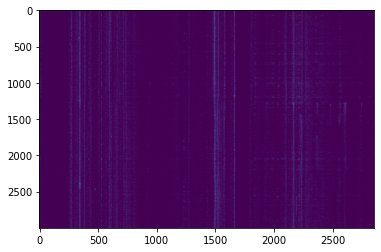

In [19]:
plt.imshow(warped_data_2d,aspect='auto')

Text(0.5, 0, 'trials')

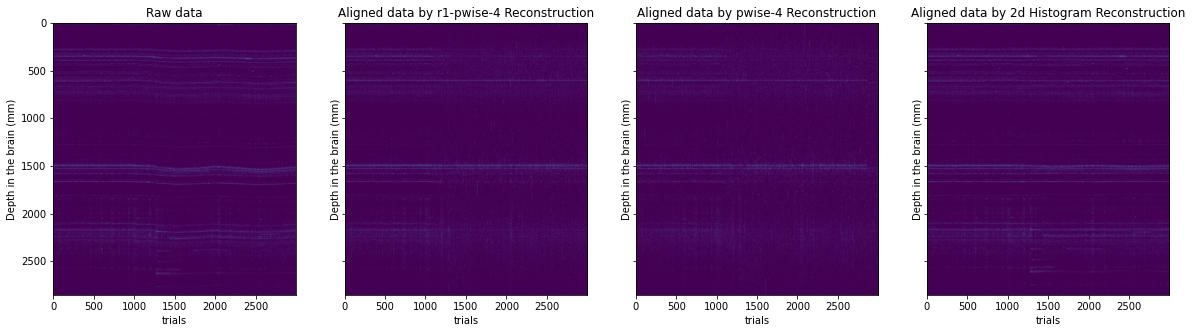

In [20]:
fig, axes = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(20, 5))
axes[0].imshow(data.squeeze().T, aspect='auto')
axes[0].set_title('Raw data')
axes[0].set_ylabel('Depth in the brain (mm)')
axes[0].set_xlabel('trials')
#plt.title('higher rank'), plt.xlabel('time (a.u.)'), plt.ylabel('trials')
#plt.colorbar();
axes[1].imshow(recon_r1pw4.squeeze().T,aspect='auto')
axes[1].set_title('Aligned data by r1-pwise-4 Reconstruction')
axes[1].set_ylabel('Depth in the brain (mm)')
axes[1].set_xlabel('trials')

axes[2].imshow(recon_pw4.squeeze().T,aspect='auto')
axes[2].set_title('Aligned data by pwise-4 Reconstruction')
axes[2].set_ylabel('Depth in the brain (mm)')
axes[2].set_xlabel('trials')

axes[3].imshow(warped_data_2d.squeeze().T,aspect='auto')
axes[3].set_title('Aligned data by 2d Histogram Reconstruction')
axes[3].set_ylabel('Depth in the brain (mm)')
axes[3].set_xlabel('trials')

In [ ]:
# plot example motion

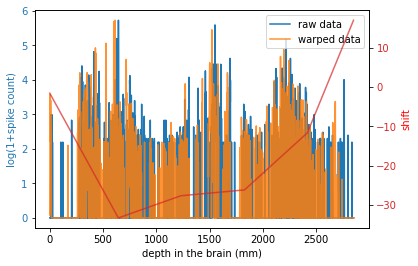

In [76]:
eg_trial=450
fig, axe = plt.subplots()


axe.set_xlabel('depth in the brain (mm)')
axe.set_ylabel('log(1+spike count)', color='tab:blue')
axe.plot(data[eg_trial,:], color='tab:blue',label='raw data')
axe.plot(transformed_data[eg_trial,:],color='tab:orange',alpha=0.85,label='warped data')
axe.tick_params(axis='y', labelcolor='tab:blue')
axe.legend()

ax2 = axe.twinx()
ax2.set_ylabel('shift', color='r')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.plot(shifts[eg_trial,:],color='tab:red',alpha=0.7)

In [19]:
np.shape(shifts)

(602, 2857, 1)

#### Compare Kilosort's 2d Histogram version of drift correction and the 1d version

##### Quantify

In [22]:
motion_dir='/home/lorenlab/Documents/MATLAB/Kilosort/Shijie/NIckData/'
motion_pos='manip.positions.npy'
motion_t='manip.timestamps_p2.npy'

motion_pos=np.load(os.path.join(motion_dir,motion_pos))
motion_t=np.load(os.path.join(motion_dir,motion_t))
motion=sp.interpolate.interp1d(motion_t.ravel(), motion_pos.ravel())

time_ind=np.arange(60*10,60*15)
motion_all=motion(time_ind)

In [23]:
path

'/home/lorenlab/Documents/MATLAB/Kilosort/Shijie/NIckData/tmp_10ofsecond/'

In [27]:
np.min(spike_times/30000)/60

8.000131111111111

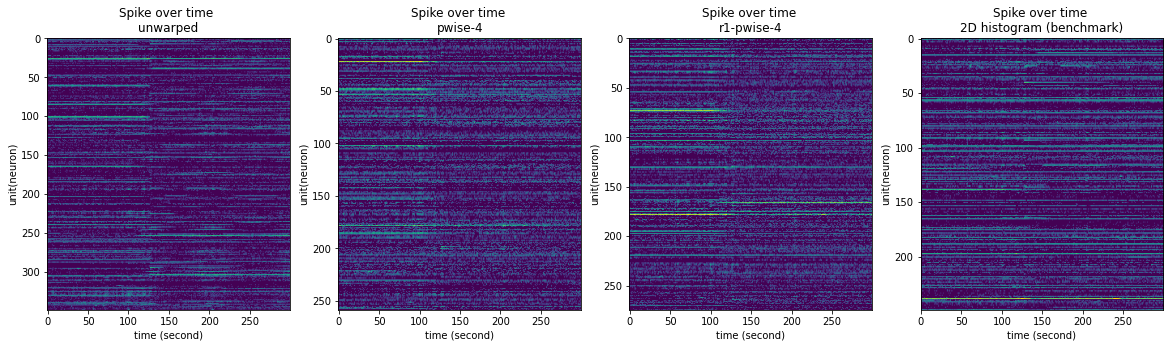

In [52]:
dirs=['unwarped','pw4','r1pw4','benchmark']
dirs_titles=['unwarped','pwise-4','r1-pwise-4','2D histogram (benchmark)']
parent_dir=path

random_ind=np.arange(len(motion_all))
np.random.shuffle(random_ind)
motion_all_random=motion_all[random_ind]

fig, axes = plt.subplots(1, 4, sharex=True, sharey=False, figsize=(20, 5))
cross_coefs={}
cross_coefs_random={}

for d_ind in range(len(dirs)):
    d=dirs[d_ind]
    sort_dir=os.path.join(parent_dir,d)
    spike_times=np.load(os.path.join(sort_dir,'spike_times.npy'))
    spike_clu=np.load(os.path.join(sort_dir,'spike_clusters.npy'))
    spike_clusters=np.unique(spike_clu)
    
    # all spikes
    spikes_all=np.zeros((max(spike_clusters)+1,300)) #10 min of data
    for t in range(len(spike_times)):
        current_cl=spike_clu[t]
        time_ind=np.floor(spike_times[t]/30000)-480
        if time_ind>0:
            spikes_all[int(current_cl),int(time_ind)]+=1
    
    # correlation coefficient
    correlate_results=np.zeros(len(spike_clusters))
    correlate_results_random=np.zeros(len(spike_clusters))
    del_ind=[]
    for c_ind in range(len(spike_clusters)):
        c=spike_clusters[c_ind]
        if np.sum(spikes_all[c,:])<=0:
            del_ind.append(c_ind)
        else:
            correlate_results[c_ind]=np.abs(np.corrcoef(spikes_all[c,:],motion_all)[0,1])
            correlate_results_random[c_ind]=np.abs(np.corrcoef(spikes_all[c,:],motion_all_random)[0,1])
    correlate_results=np.delete(correlate_results,del_ind)
    correlate_results_random=np.delete(correlate_results_random,del_ind)
    cross_coefs[d]=correlate_results
    cross_coefs_random[d]=correlate_results_random
    
    spikes_to_plot_ind=np.delete(np.arange(np.shape(spikes_all)[0]),del_ind)
    spikes_to_plot=np.log(1+spikes_all)[spikes_to_plot_ind,:]
    
    sort_ind=np.argsort(correlate_results)
    
    axes[d_ind].imshow(spikes_to_plot[sort_ind,:],aspect='auto')
    axes[d_ind].set_title('Spike over time \n'+dirs_titles[d_ind])
    axes[d_ind].set_xlabel('time (second)')
    axes[d_ind].set_ylabel('unit(neuron)')

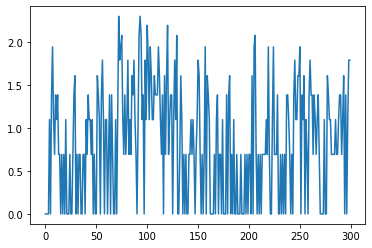

In [67]:
plt.plot(spikes_to_plot[sort_ind[0],:])

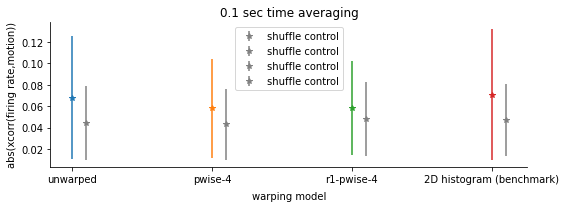

In [69]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))

for d_ind in range(len(dirs)):
    d=dirs[d_ind]
    plt.errorbar(d_ind*1, np.mean(cross_coefs[d]), np.std(cross_coefs[d]), linestyle='None', marker='*')
    plt.errorbar(d_ind*1+0.1, np.mean(cross_coefs_random[d]), np.std(cross_coefs_random[d]), color='gray',linestyle='None', marker='*',label='shuffle control')

ax.set_xticks(np.arange(len(dirs)))
ax.set_xticklabels(dirs_titles)

ax.set_ylabel("abs(xcorr(firing rate,motion))")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('warping model', labelpad=7)
ax.legend(loc='upper center')

ax.set_title('0.1 sec time averaging')
fig.tight_layout()